# dataset https://www.kaggle.com/datasets/dietzschenostoevsky/pizza-steak-sushi

In [1]:
!nvidia-smi

Fri Jan 19 19:14:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0              33W /  70W |    600MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install kaggle

In [3]:
import os



userkaggle       = 'tuchsanai'
passkaggle       = '6fb3b161875d8dd03ab318c54701a8b7'

try :
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")
   






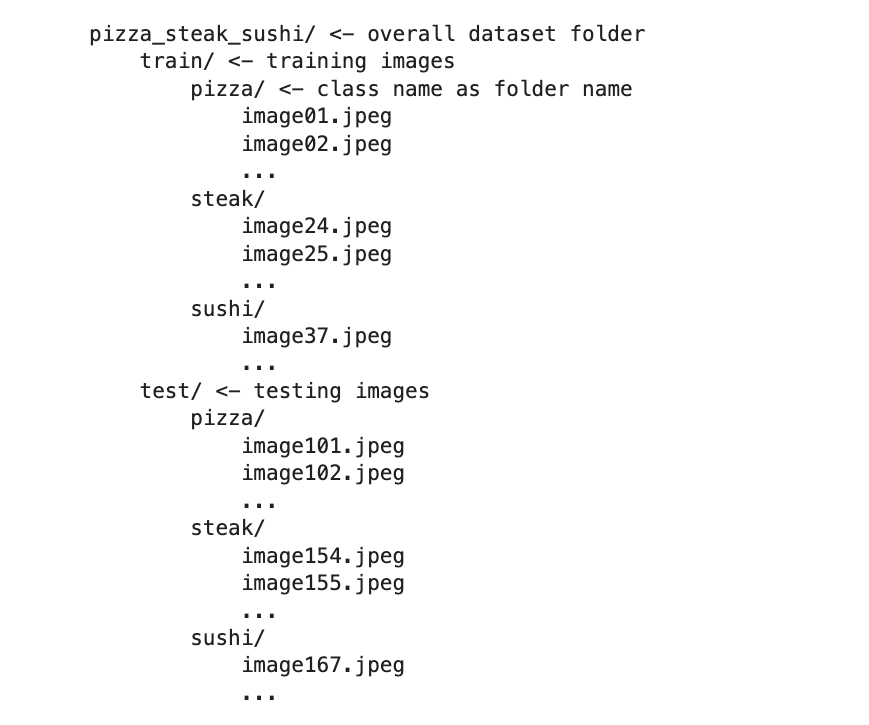

In [4]:
import os
from IPython.display import clear_output

if not os.path.exists('pizza-steak-sushi.zip'):
    # Download the dataset
    !kaggle datasets download -d dietzschenostoevsky/pizza-steak-sushi     

if os.path.exists('pizza-steak-sushi.zip') and not os.path.exists('pizza-steak-sushi'):
    # Make directory and unzip
    !unzip pizza-steak-sushi.zip -d pizza-steak-sushi
    clear_output()



In [5]:
#%% packages
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils 

#%% Dataset and data loader
path_images = './pizza-steak-sushi/data/pizza_steak_sushi/train'
LATENT_DIMS = 128



transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
   
])


In [6]:
import glob
import random

subdirectory_path = path_images   # Replace with the actual subdirectory name
image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory {subdirectory_path}')



There are 700 images in total in the subdirectory ./pizza-steak-sushi/data/pizza_steak_sushi/train


In [7]:
random_images = random.sample(image_files, 700)
print("there are {} images in random_images".format(len(random_images)))



there are 700 images in random_images


# Delete not nessary files

In [8]:
import os

for image_file in image_files:
    if image_file not in random_images:
        os.remove(image_file)

image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory ')

There are 700 images in total in the subdirectory 


In [9]:
import multiprocessing


dataset = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True , num_workers=multiprocessing.cpu_count())
# %% model class


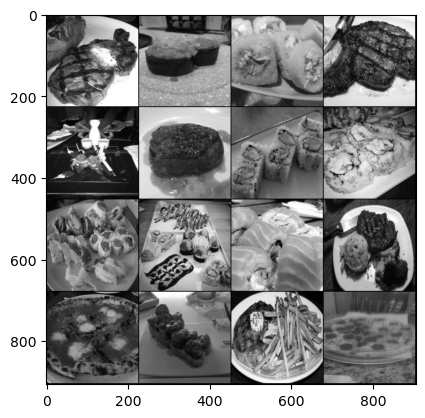

In [10]:
# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(dataloader)) 
 
# Make a grid from batch 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
 
imshow(image_grid) 


In [11]:
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        
        self.gray2rgb = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        # Encoder using ResNet18 backbone
        resnet = models.resnet18(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        # Extended layer for embedding
        self.embedding_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 512 * 7 * 7),
            nn.ReLU(),
            Unflatten(512, 7, 7),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Assuming 3-channel output (RGB)
        )

    def forward(self, x):
        x = self.gray2rgb(x)
        x = self.encoder(x)
        embedding = self.embedding_layer(x)
        x = self.decoder(embedding)
        return embedding, x

class Unflatten(nn.Module):
    def __init__(self, C, H, W):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W

    def forward(self, x):
        return x.view(-1, self.C, self.H, self.W)


input = torch.randn(5, 1, 224, 224)
model = ResNetAutoencoder()

embedding, x = model(input)
print(embedding.shape,x.shape)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([5, 512]) torch.Size([5, 1, 224, 224])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Epoch: 10 	Loss: 0.06362547592392989 	Time per epoch: 3.64374 seconds 	CPU Usage: 25.4% 	GPU Usage: 100.0%
GPU Memory Usage: 0.51 GB 	GPU Memory Cached: 2.11 GB 	CPU Memory Usage: 3.94 GB
---------------------------------------------------------------------------------------------
Epoch: 20 	Loss: 0.05731067194470337 	Time per epoch: 3.64666 seconds 	CPU Usage: 25.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.51 GB 	GPU Memory Cached: 2.11 GB 	CPU Memory Usage: 3.95 GB
---------------------------------------------------------------------------------------------
Epoch: 30 	Loss: 0.05145164392888546 	Time per epoch: 3.67483 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.51 GB 	GPU Memory Cached: 2.11 GB 	CPU Memory Usage: 3.93 GB
---------------------------------------------------------------------------------------------
Epoch: 40 	Loss: 0.04890168830752373 	Time per epoch: 3.61614 seconds 	CPU Usage: 25.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.51 GB 	GPU Memory Cached: 2

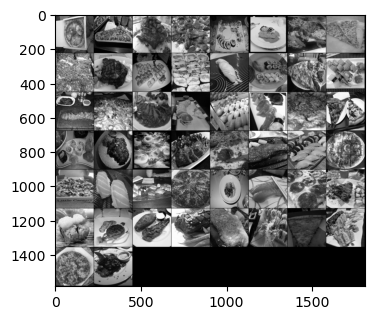

reconstructed


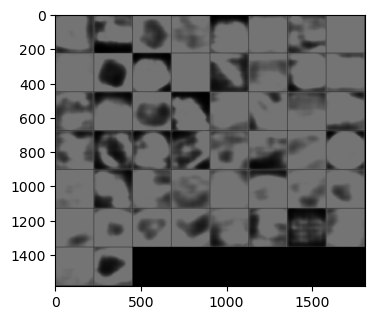

Epoch: 60 	Loss: 0.04468336222427232 	Time per epoch: 3.67313 seconds 	CPU Usage: 25.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.02 GB
---------------------------------------------------------------------------------------------
Epoch: 70 	Loss: 0.04365432821214199 	Time per epoch: 3.75181 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.01 GB
---------------------------------------------------------------------------------------------
Epoch: 80 	Loss: 0.04247052062835012 	Time per epoch: 3.61164 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.00 GB
---------------------------------------------------------------------------------------------
Epoch: 90 	Loss: 0.0420315225741693 	Time per epoch: 3.71033 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.

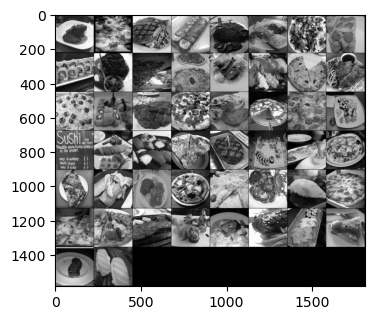

reconstructed


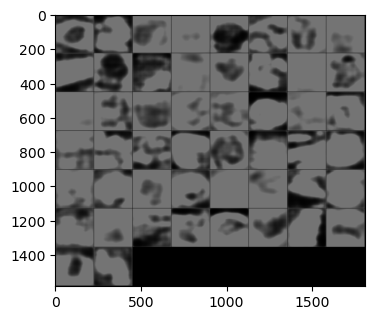

Epoch: 110 	Loss: 0.04104193140353475 	Time per epoch: 3.69143 seconds 	CPU Usage: 25.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.08 GB
---------------------------------------------------------------------------------------------
Epoch: 120 	Loss: 0.04078628176024982 	Time per epoch: 3.70384 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.09 GB
---------------------------------------------------------------------------------------------
Epoch: 130 	Loss: 0.04043965307729585 	Time per epoch: 3.68481 seconds 	CPU Usage: 25.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.08 GB
---------------------------------------------------------------------------------------------
Epoch: 140 	Loss: 0.04016023767845971 	Time per epoch: 3.71407 seconds 	CPU Usage: 25.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cache

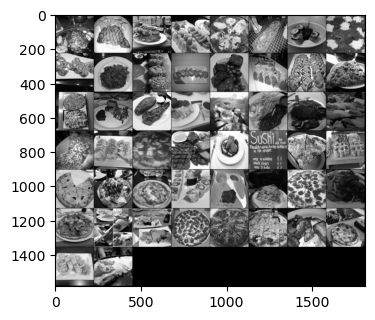

reconstructed


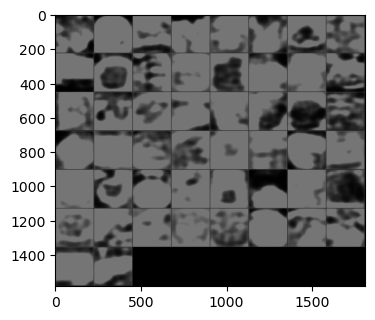

Epoch: 160 	Loss: 0.039702023778642924 	Time per epoch: 3.66817 seconds 	CPU Usage: 25.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.11 GB
---------------------------------------------------------------------------------------------
Epoch: 170 	Loss: 0.03946029261818954 	Time per epoch: 3.64336 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.12 GB
---------------------------------------------------------------------------------------------
Epoch: 180 	Loss: 0.039215673825570514 	Time per epoch: 3.65834 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.11 GB
---------------------------------------------------------------------------------------------
Epoch: 190 	Loss: 0.039041098207235336 	Time per epoch: 3.69976 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Ca

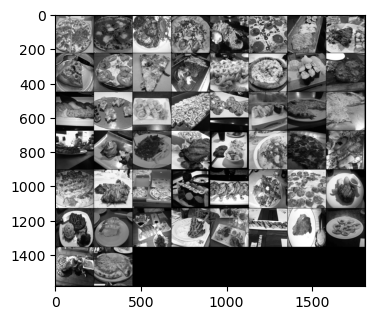

reconstructed


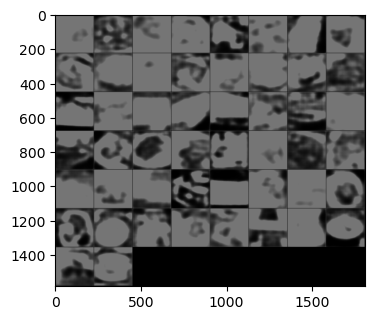

Epoch: 210 	Loss: 0.038692478356616836 	Time per epoch: 3.68354 seconds 	CPU Usage: 25.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.05 GB
---------------------------------------------------------------------------------------------
Epoch: 220 	Loss: 0.038605851254292896 	Time per epoch: 3.59269 seconds 	CPU Usage: 25.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.05 GB
---------------------------------------------------------------------------------------------
Epoch: 230 	Loss: 0.038418575056961606 	Time per epoch: 3.71632 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.05 GB
---------------------------------------------------------------------------------------------
Epoch: 240 	Loss: 0.038192999948348315 	Time per epoch: 3.68796 seconds 	CPU Usage: 25.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory C

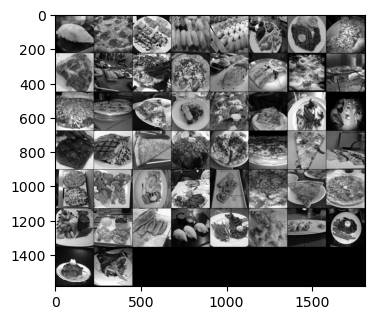

reconstructed


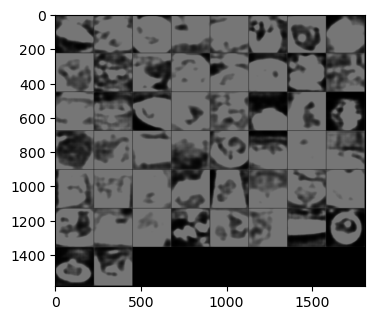

Epoch: 260 	Loss: 0.03794386796653271 	Time per epoch: 3.64326 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.09 GB
---------------------------------------------------------------------------------------------
Epoch: 270 	Loss: 0.03780740712370191 	Time per epoch: 3.72813 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.10 GB
---------------------------------------------------------------------------------------------
Epoch: 280 	Loss: 0.03765484185091087 	Time per epoch: 3.70426 seconds 	CPU Usage: 25.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.11 GB
---------------------------------------------------------------------------------------------
Epoch: 290 	Loss: 0.03753067047468254 	Time per epoch: 3.69878 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.53 GB 	GPU Memory Cache

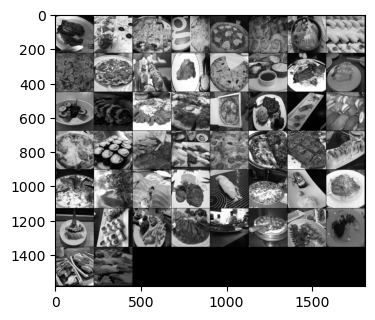

reconstructed


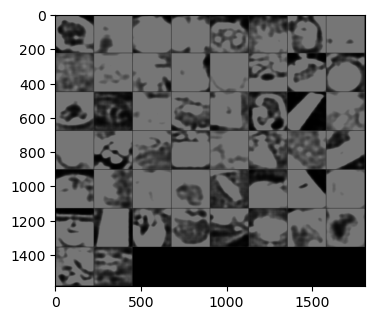

Epoch: 310 	Loss: 0.03728278007890497 	Time per epoch: 3.75370 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.08 GB
---------------------------------------------------------------------------------------------
Epoch: 320 	Loss: 0.037141463586262295 	Time per epoch: 3.67063 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.09 GB
---------------------------------------------------------------------------------------------
Epoch: 330 	Loss: 0.03703629358538559 	Time per epoch: 3.65638 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.07 GB
---------------------------------------------------------------------------------------------
Epoch: 340 	Loss: 0.03688877315393516 	Time per epoch: 3.71548 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cach

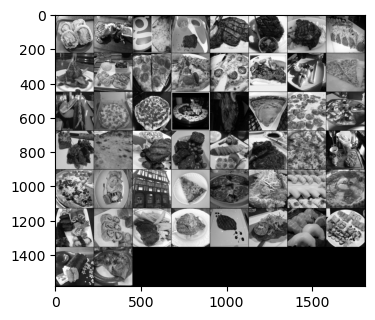

reconstructed


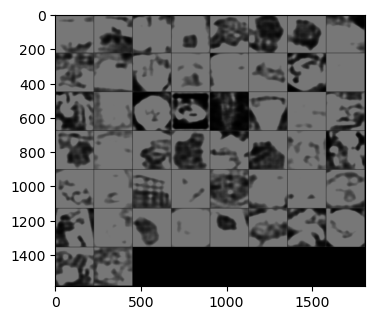

Epoch: 360 	Loss: 0.03667127261204379 	Time per epoch: 3.67777 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.16 GB
---------------------------------------------------------------------------------------------
Epoch: 370 	Loss: 0.036605178245476315 	Time per epoch: 3.66873 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.17 GB
---------------------------------------------------------------------------------------------
Epoch: 380 	Loss: 0.03649902583232948 	Time per epoch: 3.71464 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.15 GB
---------------------------------------------------------------------------------------------
Epoch: 390 	Loss: 0.03633998893201351 	Time per epoch: 3.70794 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cach

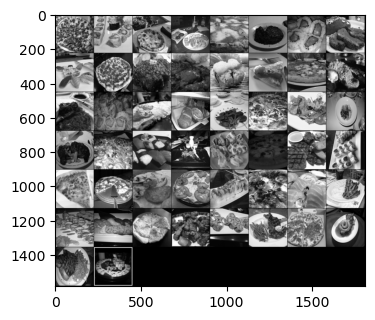

reconstructed


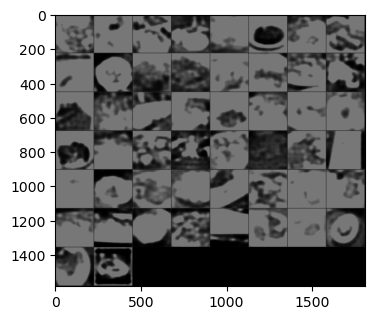

Epoch: 410 	Loss: 0.03612427519900458 	Time per epoch: 3.72188 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.22 GB
---------------------------------------------------------------------------------------------
Epoch: 420 	Loss: 0.03601768745907715 	Time per epoch: 3.68002 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 430 	Loss: 0.03591390645929745 	Time per epoch: 3.73478 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 440 	Loss: 0.03582452344042914 	Time per epoch: 3.66828 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cache

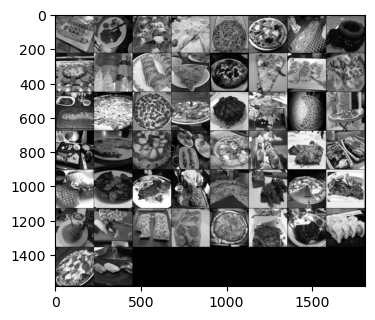

reconstructed


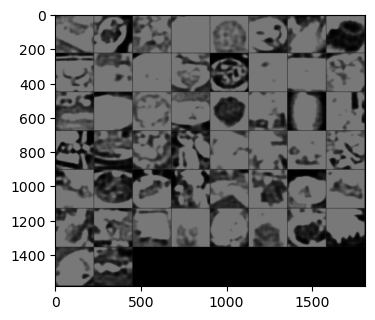

Epoch: 460 	Loss: 0.035675191453525 	Time per epoch: 3.67011 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 470 	Loss: 0.03551133203187159 	Time per epoch: 3.68110 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.23 GB
---------------------------------------------------------------------------------------------
Epoch: 480 	Loss: 0.0354002287079181 	Time per epoch: 3.73380 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 490 	Loss: 0.03533774308328118 	Time per epoch: 3.70265 seconds 	CPU Usage: 25.9% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 

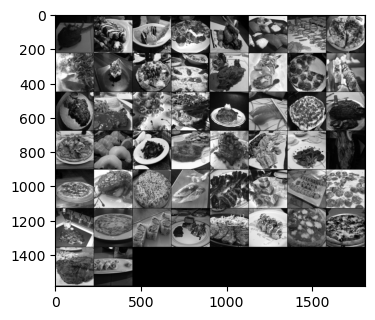

reconstructed


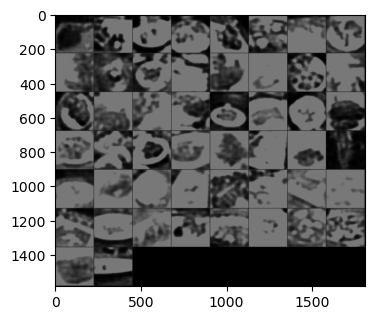

Epoch: 510 	Loss: 0.035129426047205925 	Time per epoch: 3.69328 seconds 	CPU Usage: 26.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.29 GB
---------------------------------------------------------------------------------------------
Epoch: 520 	Loss: 0.03501321002840996 	Time per epoch: 3.82353 seconds 	CPU Usage: 33.0% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.47 GB
---------------------------------------------------------------------------------------------
Epoch: 530 	Loss: 0.03491945897362062 	Time per epoch: 3.66787 seconds 	CPU Usage: 27.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.40 GB
---------------------------------------------------------------------------------------------
Epoch: 540 	Loss: 0.03481495752930641 	Time per epoch: 3.72060 seconds 	CPU Usage: 26.2% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cach

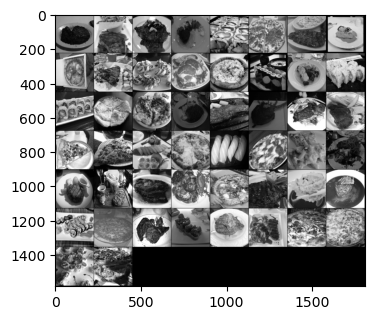

reconstructed


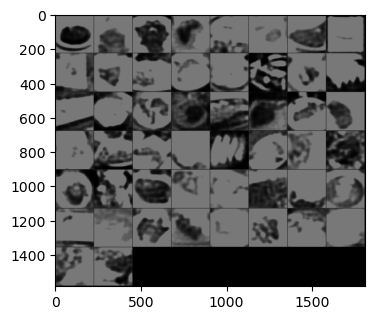

Epoch: 560 	Loss: 0.034662236060415 	Time per epoch: 3.73831 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.41 GB
---------------------------------------------------------------------------------------------
Epoch: 570 	Loss: 0.03455917537212372 	Time per epoch: 3.62995 seconds 	CPU Usage: 26.2% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.41 GB
---------------------------------------------------------------------------------------------
Epoch: 580 	Loss: 0.03450229058840445 	Time per epoch: 3.70156 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.43 GB
---------------------------------------------------------------------------------------------
Epoch: 590 	Loss: 0.034370316458599906 	Time per epoch: 3.69491 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached

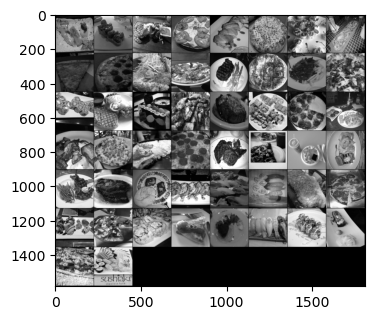

reconstructed


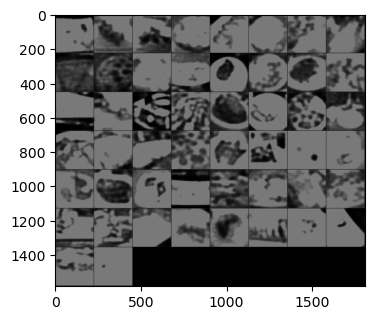

Epoch: 610 	Loss: 0.0341514331687774 	Time per epoch: 3.65118 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.45 GB
---------------------------------------------------------------------------------------------
Epoch: 620 	Loss: 0.03408896617059197 	Time per epoch: 3.67466 seconds 	CPU Usage: 26.3% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.46 GB
---------------------------------------------------------------------------------------------
Epoch: 630 	Loss: 0.03403101196246488 	Time per epoch: 3.67425 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.48 GB
---------------------------------------------------------------------------------------------
Epoch: 640 	Loss: 0.03387759705739362 	Time per epoch: 3.67010 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached

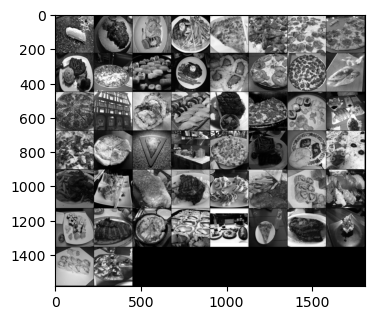

reconstructed


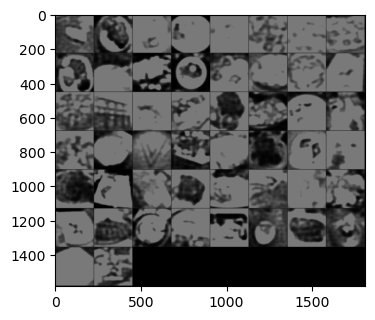

Epoch: 660 	Loss: 0.03371852183980601 	Time per epoch: 3.61734 seconds 	CPU Usage: 26.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.12 GB
---------------------------------------------------------------------------------------------
Epoch: 670 	Loss: 0.033623592528913705 	Time per epoch: 3.69216 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.15 GB
---------------------------------------------------------------------------------------------
Epoch: 680 	Loss: 0.033534307165869644 	Time per epoch: 3.69494 seconds 	CPU Usage: 26.2% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.12 GB
---------------------------------------------------------------------------------------------
Epoch: 690 	Loss: 0.03347464105380433 	Time per epoch: 3.63027 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cac

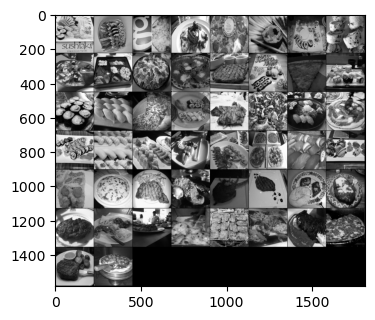

reconstructed


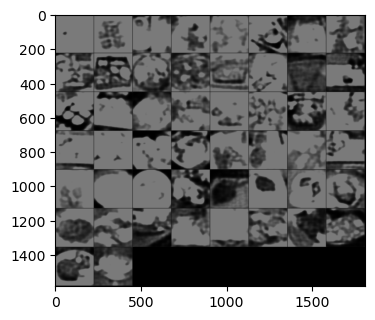

Epoch: 710 	Loss: 0.03329587874135801 	Time per epoch: 3.77600 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.19 GB
---------------------------------------------------------------------------------------------
Epoch: 720 	Loss: 0.033214208004730086 	Time per epoch: 3.71835 seconds 	CPU Usage: 26.2% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.20 GB
---------------------------------------------------------------------------------------------
Epoch: 730 	Loss: 0.033117001211004596 	Time per epoch: 3.71065 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 740 	Loss: 0.033031911057020934 	Time per epoch: 3.64582 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Ca

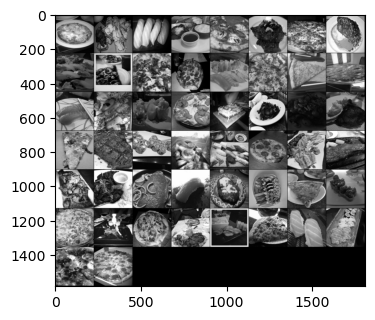

reconstructed


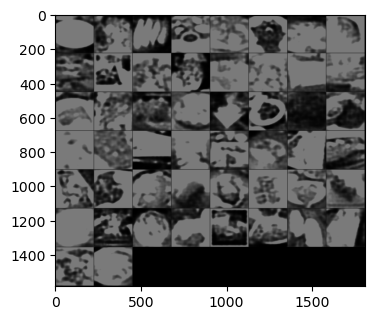

Epoch: 760 	Loss: 0.032868562399276664 	Time per epoch: 3.68830 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.20 GB
---------------------------------------------------------------------------------------------
Epoch: 770 	Loss: 0.032812761941126416 	Time per epoch: 3.59737 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.21 GB
---------------------------------------------------------------------------------------------
Epoch: 780 	Loss: 0.032698756882122586 	Time per epoch: 3.65299 seconds 	CPU Usage: 26.3% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Cached: 2.91 GB 	CPU Memory Usage: 4.22 GB
---------------------------------------------------------------------------------------------
Epoch: 790 	Loss: 0.03258830029517412 	Time per epoch: 3.67005 seconds 	CPU Usage: 26.1% 	GPU Usage: 100.0%
GPU Memory Usage: 0.52 GB 	GPU Memory Ca

In [13]:
import time
import multiprocessing
import psutil
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.cpu().numpy().transpose((1, 2, 0)) 
    plt.figure(figsize=(4, 4)) 
    plt.imshow(image_torch) 
    plt.show()

NUM_EPOCHS = 800



dataset    = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True , num_workers=multiprocessing.cpu_count())
model      = ResNetAutoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()  # Start time of the epoch
    losses_epoch = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        model.train()
        data = data.to(device)
        embedding, output = model(data)

        loss = F.mse_loss(output, data)
        losses_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0 and epoch != 0:  
        end_time = time.time()  # End time of the epoch
        epoch_time = end_time - start_time  # Time taken for the epoch
        gpu_memory_usage = torch.cuda.memory_allocated() / 1024 ** 3  # GPU memory usage in GB
        gpu_memory_cached = torch.cuda.memory_reserved() / 1024 ** 3  # GPU memory cached in GB
        cpu_memory_usage = psutil.virtual_memory().used / 1024 ** 3  # CPU memory usage in GB
        cpu_usage = psutil.cpu_percent()
        gpu_usage = torch.cuda.device_count() / torch.cuda.device_count() * 100
        print(f"Epoch: {epoch} \tLoss: {np.mean(losses_epoch)} \tTime per epoch: {epoch_time:.5f} seconds \tCPU Usage: {cpu_usage}% \tGPU Usage: {gpu_usage}%")
        print(f"GPU Memory Usage: {gpu_memory_usage:.2f} GB \tGPU Memory Cached: {gpu_memory_cached:.2f} GB \tCPU Memory Usage: {cpu_memory_usage:.2f} GB")
        print("---------------------------------------------------------------------------------------------")
        
    if epoch % 50 == 0 and epoch != 0:    
        model.eval()    
        images = data
        # %% latent space
        print('latent space')
        embedding, output = model(images)
        print('original')
        imshow(torchvision.utils.make_grid(images))
        print('reconstructed')
        imshow(torchvision.utils.make_grid(output.cpu()))   



original


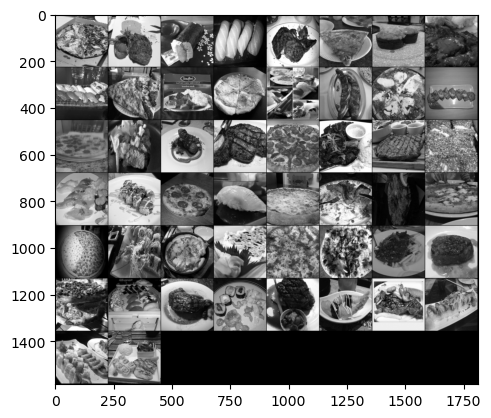

In [14]:
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 

images, labels = next(iter(dataloader))
print('original')
imshow(torchvision.utils.make_grid(images))


latent space


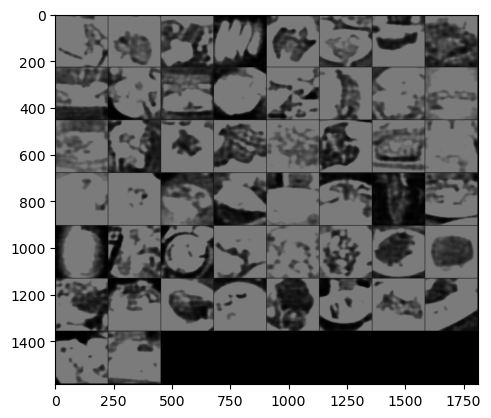

In [15]:
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 


model.eval()    
images = images.to(device)
# %% latent space
print('latent space')
embedding, output = model(images)
imshow(torchvision.utils.make_grid(output.cpu()))

